## Set-up repo

In [ ]:
!git clone https://github.com/MahanFathi/NxDP.git
%cd NxDP
# !python main.py --opts TRAIN.NUM_TIMESTEPS 10000000 ENV.ENV_NAME ant

import os
os.environ['PYTHONPATH'] += ":/content/NxDP"

Cloning into 'NxDP'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 114 (delta 50), reused 107 (delta 43), pack-reused 0
Receiving objects: 100% (114/114), 591.39 KiB | 5.48 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/NxDP


## TPU Settings

In [ ]:
# Runtime > Change runtime type > select TPU
if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

## Imports

In [ ]:
try:
  import brax
except ImportError:
  from IPython.display import HTML, clear_output, Image
  !pip install git+https://github.com/google/brax.git@main
  import brax

!pip install yacs

from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output

from brax import jumpy as jp
from brax import envs
from brax.io import html
from brax.io import model
from brax.io import image

from config.defaults import get_cfg_defaults
from train import train

clear_output()

## Config

In [ ]:
# build default config
cfg = get_cfg_defaults()

## Select environment 

In [ ]:
#@title Preview a Brax environment { run: "auto" }
#@markdown Select the environment to train:

env_name = "ant"  # @param ['inverted_pendulum', 'inverted_double_pendulum', 'ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'ur5e', 'reacher']
cfg.ENV.ENV_NAME = env_name

env_fn = envs.create_fn(env_name=env_name)
env = env_fn()
state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

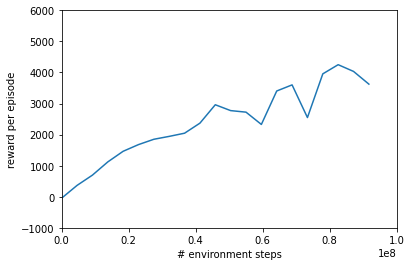

In [ ]:
cfg.TRAIN.NUM_TIMESTEPS = 1e8
cfg.TRAIN.NUM_ENVS = 2048
cfg.TRAIN.UNROLL_LENGTH = 20
# cfg.DMP.UNROLL_LENGTH = 1 # reduces to PPO (works best)
# cfg.freeze()

xdata = []
ydata = []
times = [datetime.now()]

max_y = {
    'inverted_double_pendulum': 5000,
    'inverted_pendulum': 1100,
    'ant': 6000, 
    'humanoid': 12000, 
    'fetch': 15, 
    'grasp': 100, 
    'halfcheetah': 8000,
    'ur5e': 10,
    'reacher': 5}[cfg.ENV.ENV_NAME]

min_y = {'reacher': -100, 'ant': -1000}.get(cfg.ENV.ENV_NAME, 0)

def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics['eval/episode_reward'])
    clear_output(wait=True)
    plt.xlim([0, cfg.TRAIN.NUM_TIMESTEPS])
    plt.ylim([min_y, max_y])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.plot(xdata, ydata)
    plt.show()

inference_fn, params, metrics = train(cfg, env_fn, progress_fn=progress)


## Visualization

In [ ]:
import jax
from jax import numpy as jnp

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=0)
state = jit_env_reset(rng=rng)
while not state.done:
  act_rng, rng = jax.random.split(rng)
  actions = jit_inference_fn(params, jnp.expand_dims(state.obs, 0), act_rng)
  actions = actions.reshape([actions.shape[0], -1])
  for action in actions: # evaluation is open-loop (non-MPC)
    rollout.append(state)
    state = jit_env_step(state, action)

HTML(html.render(env.sys, [s.qp for s in rollout]))

In [ ]:
Image(image.render(env.sys, [s.qp for s in rollout[:100]], width=320, height=240))